In [53]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
splits = ['random', 'scaffold', 'protein']
datasets = ['pdbbind']
tasks = ['all', 'easy', 'hard']
results_dir = 'results/'
iterations = range(5)

In [47]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()

In [48]:
for dataset in datasets :
    for split in splits :
        for iteration in iterations :
            for task in tasks :
                dataset_results_path = os.path.join(f'results/{split}_split_{iteration}_molsize_{dataset}/', 
                                                    f'dataset_results_{task}.p')
                if os.path.exists(dataset_results_path) :
                    with open(dataset_results_path, 'rb') as f:
                        dataset_results = pickle.load(f)

                    dataset_results['bioactive_accuracy']['split'] = split
                    dataset_results['bioactive_accuracy']['dataset'] = dataset
                    dataset_results['bioactive_accuracy']['task'] = task
                    bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy']), ignore_index=True)

                    for average_type in dataset_results['regression'] :
                        dataset_results['regression'][average_type]['split'] = split
                        dataset_results['regression'][average_type]['dataset'] = dataset
                        dataset_results['regression'][average_type]['task'] = task
                        dataset_results['regression'][average_type]['average_type'] = average_type
                        regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

                    for ranker in dataset_results['ranking'] :
                        dataset_results['ranking'][ranker]['split'] = split
                        dataset_results['ranking'][ranker]['dataset'] = dataset
                        dataset_results['ranking'][ranker]['task'] = task
                        dataset_results['ranking'][ranker]['ranker'] = ranker
                        ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

# Regression

In [49]:
regression_df['subset'] = regression_df['task']

In [50]:
regression_df.head()

,average_type,dataset,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,split,task,subset
0,Micro,pdbbind,0.644865,0.664456,0.410618,0.429809,0.761913,1.597044,0.725309,0.599464,0.612574,random,all,all
1,Macro,pdbbind,NaN,NaN,-2.134894,-16.393450,0.681255,1.666228,0.629667,NaN,NaN,random,all,all
2,Micro,pdbbind,0.461648,0.464032,0.155430,0.176918,0.629404,1.038688,0.577428,0.378649,0.356895,random,easy,easy
3,Macro,pdbbind,NaN,NaN,-4.895186,-47.943826,0.590728,1.085828,0.511973,NaN,NaN,random,easy,easy
4,Micro,pdbbind,0.613825,0.639428,0.368735,0.392769,0.778269,1.912250,0.742339,0.564278,0.581578,random,hard,hard


In [51]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [54]:
rmselabel = 'Mean RMSE'
r2label = 'R2'
new_data = regression_df[(regression_df['average_type'] == 'Micro') 
                         & (regression_df['task'] == 'all')]
all_data = new_data[['split', 'rmse_all', 'r2_all']]
all_data = all_data.rename({'rmse_all' : rmselabel, 'r2_all' : r2label}, axis=1)
all_data['Conformation subset'] = 'All'
gen_data = new_data[['split', 'rmse_gen', 'r2_gen']]
gen_data = gen_data.rename({'rmse_gen' : rmselabel, 'r2_gen' : r2label}, axis=1)
gen_data['Conformation subset'] = 'Generated'
bio_data = new_data[['split', 'rmse_bio']]
bio_data = bio_data.rename({'rmse_bio' : rmselabel}, axis=1)
bio_data['Conformation subset'] = 'Bioactive'
merged_data = pd.concat([all_data, gen_data, bio_data])

grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({rmselabel : [custom_agg],
                                                                                     r2label : [custom_agg]})
grouped_data = grouped_data.unstack(0)
grouped_data = grouped_data.droplevel(1, axis=1)
grouped_data.index.name = 'Split'
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data = grouped_data.swaplevel(axis=1)
grouped_data = grouped_data.sort_index(axis=1)

In [55]:
grouped_data

Conformation subset          All                 Bioactive        Generated  \
                       Mean RMSE           R2    Mean RMSE  R2    Mean RMSE   
Split                                                                         
Random               0.76 ± 0.01  0.39 ± 0.01  1.64 ± 0.04  NA  0.71 ± 0.01   
Scaffold             0.75 ± 0.02  0.36 ± 0.04  1.78 ± 0.06  NA  0.72 ± 0.02   
Protein              0.73 ± 0.02  0.39 ± 0.03  1.68 ± 0.06  NA  0.71 ± 0.02   

Conformation subset               
                              R2  
Split                             
Random               0.42 ± 0.01  
Scaffold             0.38 ± 0.04  
Protein              0.41 ± 0.03

In [7]:
def r2_results(dataset) :
    ylabel = 'R2'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'r2_all']]
    all_data = all_data.rename({'r2_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'r2_gen']]
    gen_data = gen_data.rename({'r2_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    merged_data = pd.concat([all_data, gen_data])

    grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({ylabel : ['mean', 'std']})
    grouped_data.round(2)
    
    return grouped_data

In [8]:
grouped_data = r2_results('pdbbind')
grouped_data.round(2)

R2      
                              mean   std
Conformation subset split               
All                 random    0.39  0.01
                    scaffold  0.36  0.04
                    protein   0.39  0.03
Generated           random    0.42  0.01
                    scaffold  0.38  0.04
                    protein   0.41  0.03

In [9]:
grouped_data = r2_results('platinum')
grouped_data.round(2)

Empty DataFrame
Columns: [(R2, mean), (R2, std)]
Index: []

In [10]:
def rmse_results(dataset) : 
    ylabel = 'Mean RMSE'
    new_data = regression_df[(regression_df['dataset'] == dataset) 
                             & (regression_df['average_type'] == 'Micro') 
                             & (regression_df['task'] == 'all')]
    all_data = new_data[['split', 'rmse_all']]
    all_data = all_data.rename({'rmse_all' : ylabel}, axis=1)
    all_data['Conformation subset'] = 'All'
    gen_data = new_data[['split', 'rmse_gen']]
    gen_data = gen_data.rename({'rmse_gen' : ylabel}, axis=1)
    gen_data['Conformation subset'] = 'Generated'
    bio_data = new_data[['split', 'rmse_bio']]
    bio_data = bio_data.rename({'rmse_bio' : ylabel}, axis=1)
    bio_data['Conformation subset'] = 'Bioactive'
    merged_data = pd.concat([all_data, gen_data, bio_data])

    grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({ylabel : ['mean', 'std']})
    return grouped_data

In [11]:
grouped_data = rmse_results('pdbbind')
grouped_data.round(2)

Mean RMSE      
                                  mean   std
Conformation subset split                   
All                 random        0.76  0.01
                    scaffold      0.75  0.02
                    protein       0.73  0.02
Generated           random        0.71  0.01
                    scaffold      0.72  0.02
                    protein       0.71  0.02
Bioactive           random        1.64  0.04
                    scaffold      1.78  0.06
                    protein       1.68  0.06

In [12]:
grouped_data = rmse_results('platinum')
grouped_data.round(2)

Empty DataFrame
Columns: [(Mean RMSE, mean), (Mean RMSE, std)]
Index: []

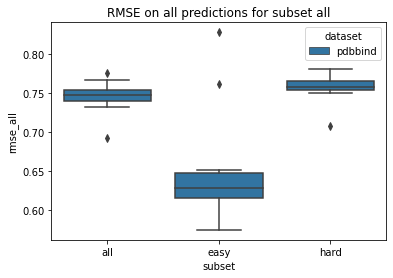

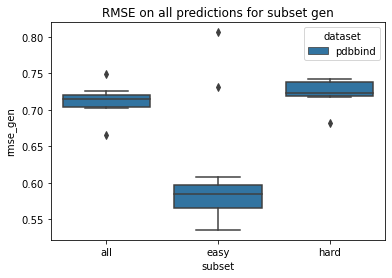

In [13]:
data = regression_df[(regression_df['average_type'] == 'Micro')]
for subset in ['all', 'gen'] :
    sns.boxplot(data=data, x='subset', y=f'rmse_{subset}', hue='dataset')
    plt.title(f'RMSE on all predictions for subset {subset}')
    plt.savefig(f'figures/rmse_{subset}.png', dpi=200)
    plt.show()

In [14]:
bioactive_accuracy_df['subset'] = bioactive_accuracy_df['task']

In [15]:
bioactive_accuracy_df.head()

,dataset,energy,model,random,split,task,subset
0,pdbbind,"{'q1_all_bioactive': 4.0, 'median_all_bioactiv...","{'q1_all_bioactive': 27.0, 'median_all_bioacti...","{'q1_all_bioactive': 10.0, 'median_all_bioacti...",random,all,all
1,pdbbind,"{'q1_all_bioactive': 2.0, 'median_all_bioactiv...","{'q1_all_bioactive': 6.0, 'median_all_bioactiv...","{'q1_all_bioactive': 3.0, 'median_all_bioactiv...",random,easy,easy
2,pdbbind,"{'q1_all_bioactive': 10.0, 'median_all_bioacti...","{'q1_all_bioactive': 51.0, 'median_all_bioacti...","{'q1_all_bioactive': 25.0, 'median_all_bioacti...",random,hard,hard
3,pdbbind,"{'q1_all_bioactive': 4.0, 'median_all_bioactiv...","{'q1_all_bioactive': 27.0, 'median_all_bioacti...","{'q1_all_bioactive': 10.0, 'median_all_bioacti...",random,all,all
4,pdbbind,"{'q1_all_bioactive': 2.0, 'median_all_bioactiv...","{'q1_all_bioactive': 6.0, 'median_all_bioactiv...","{'q1_all_bioactive': 3.0, 'median_all_bioactiv...",random,easy,easy


In [16]:
ranking_df['subset'] = ranking_df['task']

In [17]:
ranking_df

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
0,0.345205,pdbbind,1.241294,1.083615,1.066367,1.097390,1.097981,1.061818,1.049181,1.049385,...,1.002567,1.002115,1.000562,0.999513,1.000631,1.0,random,random,all,all
1,0.399145,pdbbind,1.437077,1.501719,1.373985,1.330023,1.320237,1.282953,1.259048,1.260507,...,1.005651,1.002393,1.000938,1.000520,0.999646,1.0,energy,random,all,all
2,0.403042,pdbbind,1.306157,1.277366,1.244438,1.199303,1.242182,1.203987,1.196499,1.191798,...,0.998919,0.998058,0.997936,0.998438,1.000540,1.0,ccdc,random,all,all
3,0.363766,pdbbind,1.306157,1.176050,1.174264,1.079808,1.080553,1.049871,1.037479,1.030391,...,1.000212,1.001885,1.002245,1.001057,1.000540,1.0,model,random,all,all
4,0.618660,pdbbind,1.051194,1.053544,1.058467,1.036751,1.031067,1.015517,1.017916,1.024223,...,0.999582,1.001487,1.000407,1.000393,1.000000,1.0,random,random,easy,easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.639316,pdbbind,1.282000,1.166339,1.153145,1.122298,1.127079,1.097593,1.072902,1.072273,...,1.001929,1.000760,1.000492,1.000260,1.000000,1.0,model,protein,easy,easy
176,0.168658,pdbbind,0.995911,0.922545,0.883235,0.957070,0.954952,0.970758,0.976868,0.976868,...,1.004265,1.004342,1.002231,1.002422,0.999314,1.0,random,protein,hard,hard
177,0.224799,pdbbind,1.461987,1.477788,1.333035,1.430924,1.340743,1.318029,1.278111,1.278111,...,1.009360,1.008876,1.007523,1.004708,1.001499,1.0,energy,protein,hard,hard
178,0.222883,pdbbind,1.686968,1.395689,1.326027,1.250534,1.249032,1.195445,1.169927,1.169927,...,1.008653,1.004041,1.002498,1.001190,0.999447,1.0,ccdc,protein,hard,hard


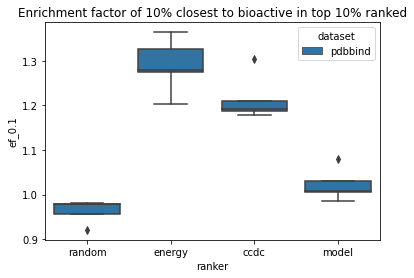

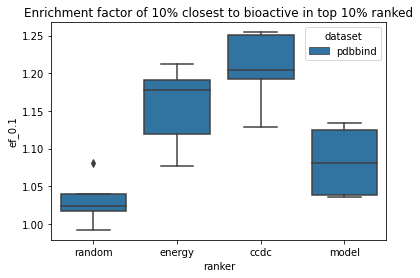

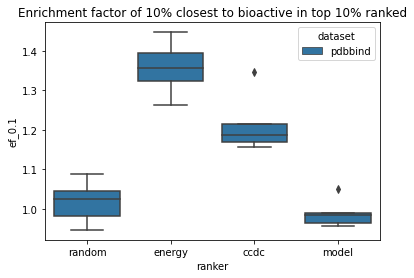

In [18]:
for subset in ['all', 'easy', 'hard'] :
    data = ranking_df[(ranking_df['split'] == 'scaffold') & (ranking_df['subset'] == subset)]
    sns.boxplot(data=data, x='ranker', y='ef_0.1', hue='dataset')
    plt.title('Enrichment factor of 10% closest to bioactive in top 10% ranked')
    plt.savefig(f'figures/ef_10_{subset}.png', dpi=200)
    plt.show()

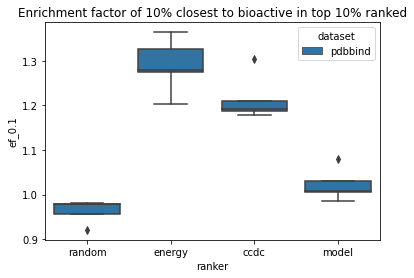

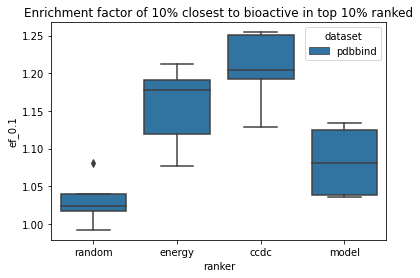

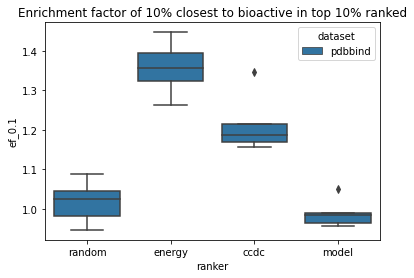

In [19]:
for subset in ['all', 'easy', 'hard'] :
    data = ranking_df[(ranking_df['split'] == 'scaffold') & (ranking_df['subset'] == subset)]
    sns.boxplot(data=data, x='ranker', y='ef_0.1', hue='dataset')
    plt.title('Enrichment factor of 10% closest to bioactive in top 10% ranked')
    plt.savefig(f'figures/ef_10_{subset}.png', dpi=200)
    plt.show()

In [20]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
data

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
63,0.341654,pdbbind,1.477771,1.272978,1.134065,1.103539,1.078320,1.076642,1.051106,1.056144,...,0.999012,0.997937,0.998466,1.000961,1.000724,1.0,model,scaffold,all,all
75,0.351669,pdbbind,1.259772,1.108033,0.996714,0.996620,1.030802,1.018710,0.994851,0.989239,...,1.000549,1.001176,1.002131,1.002172,1.000866,1.0,model,scaffold,all,all
87,0.291368,pdbbind,1.354914,1.205956,1.045241,1.003716,0.940616,0.934205,0.935416,0.933128,...,0.998803,0.999455,0.999953,1.001227,1.000481,1.0,model,scaffold,all,all
99,0.317343,pdbbind,1.439756,1.126537,1.067969,1.094152,1.022485,1.033337,1.023804,1.025161,...,1.001348,0.998994,0.997797,0.997758,0.998213,1.0,model,scaffold,all,all
111,0.312199,pdbbind,1.406541,1.169587,1.101892,1.087221,1.074291,1.072632,1.035556,1.034748,...,0.999972,1.000623,1.000704,1.002802,1.001825,1.0,model,scaffold,all,all


In [21]:
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.0220070997316386
0.03617605059196998


In [22]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
62,0.374221,pdbbind,1.477771,1.456424,1.370967,1.334722,1.308117,1.278149,1.229498,1.235447,...,1.004369,1.000846,1.000425,1.001132,1.000724,1.0,ccdc,scaffold,all,all
74,0.395839,pdbbind,1.259772,1.252826,1.224343,1.219139,1.268522,1.268165,1.213863,1.214316,...,1.007108,1.004588,1.002576,1.001567,1.000866,1.0,ccdc,scaffold,all,all
86,0.335704,pdbbind,1.354914,1.269743,1.243138,1.207347,1.244923,1.218164,1.177801,1.171892,...,1.001550,0.999193,0.999975,0.998726,1.000481,1.0,ccdc,scaffold,all,all
98,0.361662,pdbbind,1.439756,1.426423,1.426010,1.373918,1.340112,1.297014,1.238214,1.234104,...,1.000956,0.998193,0.998844,0.996687,0.998213,1.0,ccdc,scaffold,all,all
110,0.353537,pdbbind,1.406541,1.456871,1.405766,1.400196,1.375355,1.388610,1.335249,1.330278,...,1.007750,1.006591,1.004200,1.002160,1.001825,1.0,ccdc,scaffold,all,all


In [23]:
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.2147972659126256
0.05128009047205952


In [24]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'easy')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.082326217013801
0.046187929824696425


In [25]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'easy')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.205939984041897
0.05146732817809204


In [26]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'hard')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

0.988561305360113
0.0373549669697226


In [27]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'hard')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data
print(data['ef_0.1'].mean())
print(data['ef_0.1'].std())

1.2151300655597617
0.07733258255147808


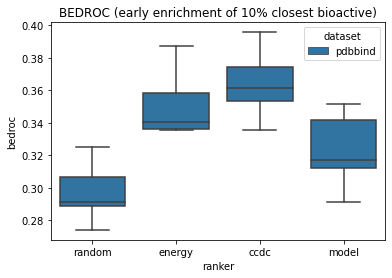

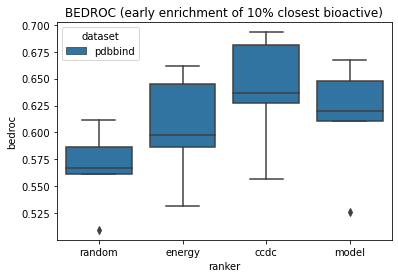

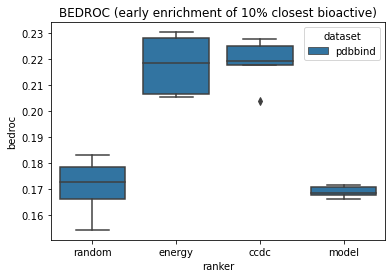

In [28]:
for subset in ['all', 'easy', 'hard'] :
    data = ranking_df[(ranking_df['split'] == 'scaffold') & (ranking_df['subset'] == subset)]
    sns.boxplot(data=data, x='ranker', y='bedroc', hue='dataset')
    plt.title('BEDROC (early enrichment of 10% closest bioactive)')
    plt.savefig(f'figures/bedroc_{subset}.png', dpi=200)
    plt.show()

In [29]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'model')]
data

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
63,0.341654,pdbbind,1.477771,1.272978,1.134065,1.103539,1.078320,1.076642,1.051106,1.056144,...,0.999012,0.997937,0.998466,1.000961,1.000724,1.0,model,scaffold,all,all
75,0.351669,pdbbind,1.259772,1.108033,0.996714,0.996620,1.030802,1.018710,0.994851,0.989239,...,1.000549,1.001176,1.002131,1.002172,1.000866,1.0,model,scaffold,all,all
87,0.291368,pdbbind,1.354914,1.205956,1.045241,1.003716,0.940616,0.934205,0.935416,0.933128,...,0.998803,0.999455,0.999953,1.001227,1.000481,1.0,model,scaffold,all,all
99,0.317343,pdbbind,1.439756,1.126537,1.067969,1.094152,1.022485,1.033337,1.023804,1.025161,...,1.001348,0.998994,0.997797,0.997758,0.998213,1.0,model,scaffold,all,all
111,0.312199,pdbbind,1.406541,1.169587,1.101892,1.087221,1.074291,1.072632,1.035556,1.034748,...,0.999972,1.000623,1.000704,1.002802,1.001825,1.0,model,scaffold,all,all


In [30]:
print(data['bedroc'].mean())
print(data['bedroc'].std())

0.32284640740049875
0.024078122302458607


In [31]:
data = ranking_df[(ranking_df['split'] == 'scaffold') 
                  & (ranking_df['subset'] == 'all')
                  & (ranking_df['dataset'] == 'pdbbind')
                  & (ranking_df['ranker'] == 'ccdc')]
data

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,ef_0.95,ef_0.96,ef_0.97,ef_0.98,ef_0.99,ef_1.0,ranker,split,task,subset
62,0.374221,pdbbind,1.477771,1.456424,1.370967,1.334722,1.308117,1.278149,1.229498,1.235447,...,1.004369,1.000846,1.000425,1.001132,1.000724,1.0,ccdc,scaffold,all,all
74,0.395839,pdbbind,1.259772,1.252826,1.224343,1.219139,1.268522,1.268165,1.213863,1.214316,...,1.007108,1.004588,1.002576,1.001567,1.000866,1.0,ccdc,scaffold,all,all
86,0.335704,pdbbind,1.354914,1.269743,1.243138,1.207347,1.244923,1.218164,1.177801,1.171892,...,1.001550,0.999193,0.999975,0.998726,1.000481,1.0,ccdc,scaffold,all,all
98,0.361662,pdbbind,1.439756,1.426423,1.426010,1.373918,1.340112,1.297014,1.238214,1.234104,...,1.000956,0.998193,0.998844,0.996687,0.998213,1.0,ccdc,scaffold,all,all
110,0.353537,pdbbind,1.406541,1.456871,1.405766,1.400196,1.375355,1.388610,1.335249,1.330278,...,1.007750,1.006591,1.004200,1.002160,1.001825,1.0,ccdc,scaffold,all,all


In [32]:
print(data['bedroc'].mean())
print(data['bedroc'].std())

0.3641925492053179
0.02254750407391985


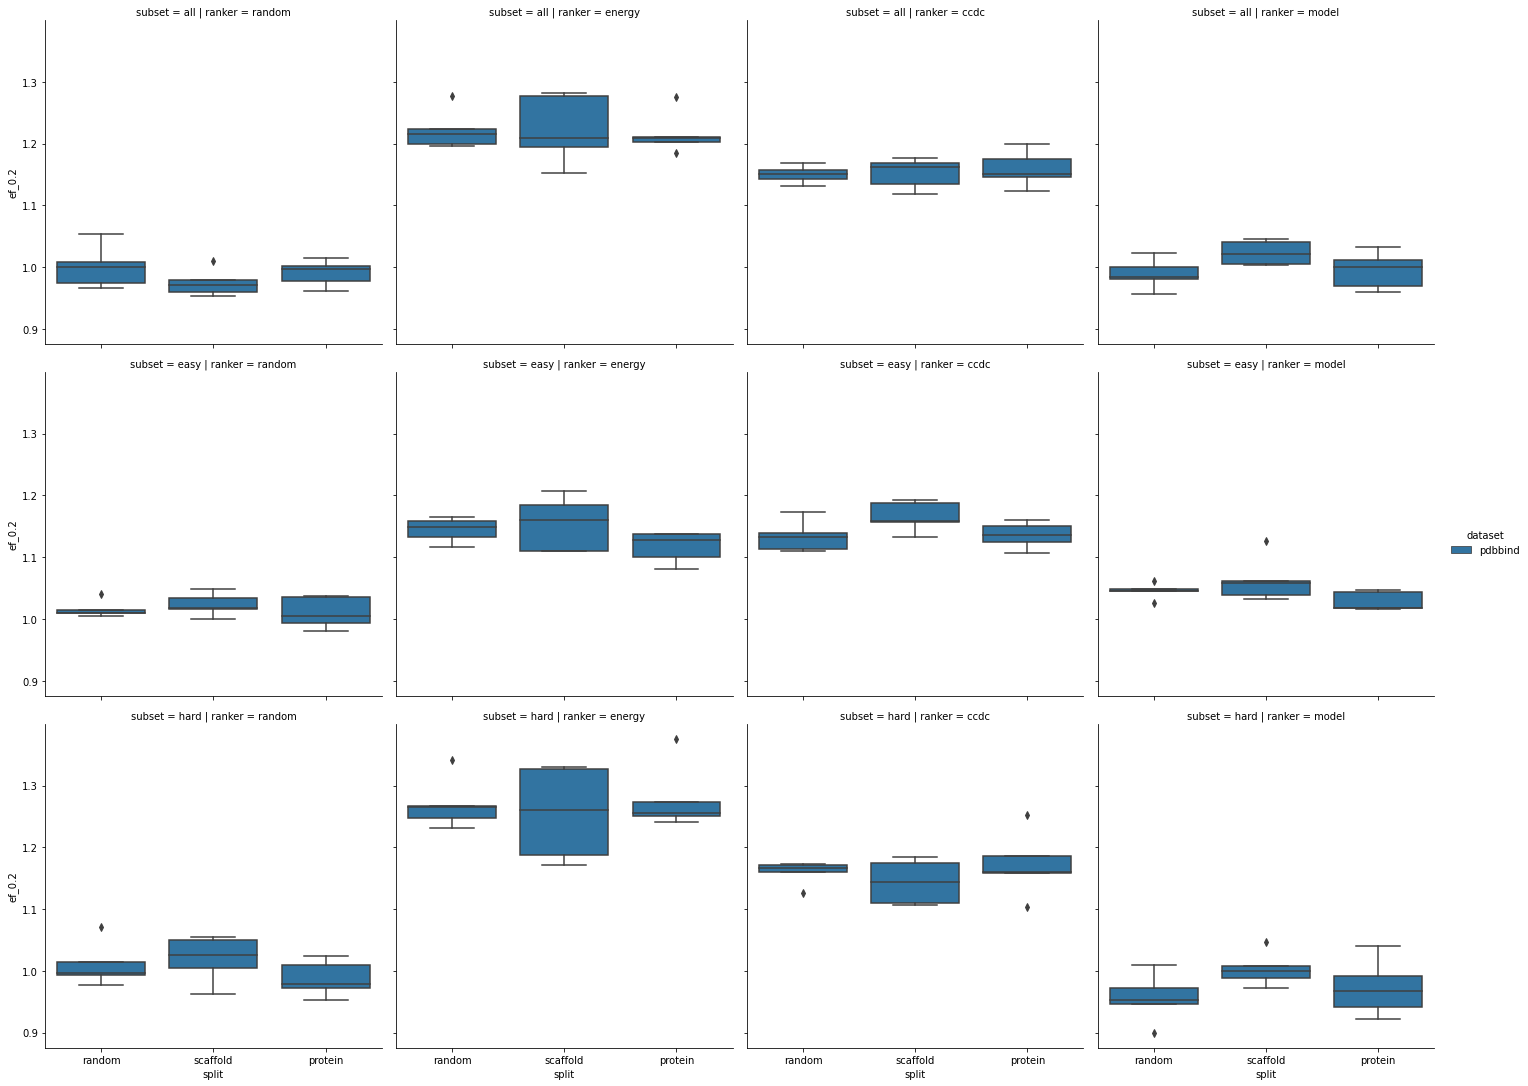

In [33]:
sns.catplot(data=ranking_df, x='split', y='ef_0.2', hue='dataset', row='subset', col='ranker', kind='box')

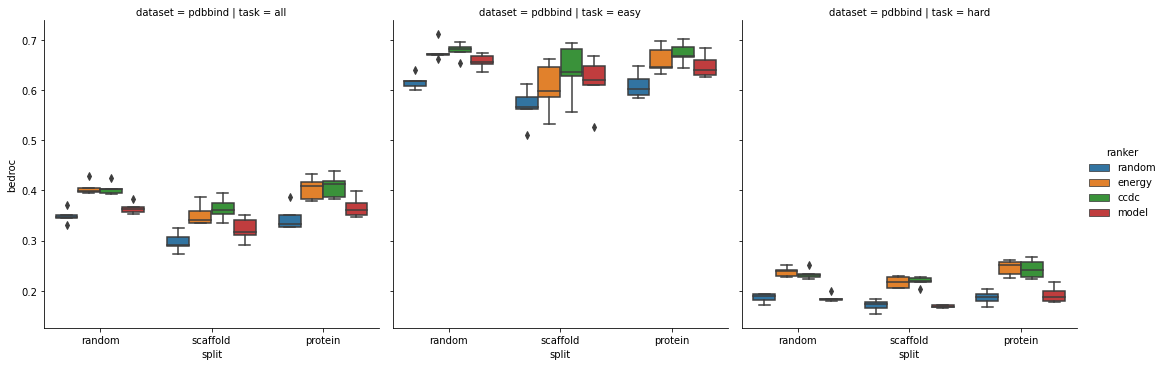

In [34]:
sns.catplot(data=ranking_df, x='split', y='bedroc', hue='ranker', row='dataset', col='task', kind='box')

In [35]:
dataset_results

{'regression': {'Micro': {'rmse_all': 0.7572178,
   'rmse_gen': 0.72865546,
   'rmse_bio': 2.0506096,
   'r2_all': 0.3192816456470602,
   'r2_gen': 0.3419171892418392,
   'pearson_all': 0.567024845003152,
   'pearson_gen': 0.5856166300743396,
   'spearman_all': 0.5343684558484065,
   'spearman_gen': 0.5459829732008904,
   'split': 'protein',
   'dataset': 'pdbbind',
   'task': 'hard',
   'average_type': 'Micro'},
  'Macro': {'rmse_all': 0.70959675,
   'rmse_gen': 0.6775531,
   'rmse_bio': 2.050683,
   'r2_all': -1.053769435934916,
   'r2_gen': -1.3701651034602722,
   'pearson_all': nan,
   'pearson_gen': nan,
   'spearman_all': nan,
   'spearman_gen': nan,
   'split': 'protein',
   'dataset': 'pdbbind',
   'task': 'hard',
   'average_type': 'Macro'}},
 'bioactive_accuracy': {'model': {'q1_all_bioactive': 100.0,
   'median_all_bioactive': 100.0,
   'q3_all_bioactive': 100.0,
   'q1_min_bioactive': 100.0,
   'median_min_bioactive': 100.0,
   'q3_min_bioactive': 100.0,
   'q1_normalized_b

In [36]:
for metric, value in dataset_results['bioactive_accuracy'].items() :
    bioactive_accuracy_df.loc[evaluation_name, metric] = value

NameError: name 'evaluation_name' is not defined

In [ ]:
bioactive_accuracy_df